### About the Dataset

Heart failure is a common event caused by Cardiovascular diseases CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

#### Importing Libararies

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import IsolationForest
import opendatasets as od
from ydata_profiling import ProfileReport

#### Loading the dataset

In [21]:
# Load data
od.download("https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data")
df = pd.read_csv(fr'C:\Users\Sarah\Desktop\last_project\heart-failure-clinical-data\heart_failure_clinical_records_dataset.csv')

Skipping, found downloaded files in ".\heart-failure-clinical-data" (use force=True to force download)


#### Exploratory Data Analysis 

In [22]:
#profile report
profile= ProfileReport(df)
profile.to_file(output_file="analysis_01.html");

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


WE can Interpret many things from the Report 
- the dataset have a high range of people in age group 60's
- the people with anamia is 129 and non anamic is 170 
- more people have diabetes that is 174 and non diabetic are 125 
- there are more males and less females with ratio 194 /105
- most people smoke with cout of 203 and 96 donot
- 96 people died in this follow up period where as 203 are alive 
- there are many classes eg 'creatinine_phosphokinase' whose class distribution is highly skewed


In [23]:
# Check for missing values
print(df.isnull().sum())

# Remove any rows with missing values
df = df.dropna()

# EDA
df.describe().T


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


- there is no missing or null values in the dataset 
- age starts from 40 to 95 

In [24]:
#shape 
df.shape

(299, 13)

- 299 records and 13 features 
- 13 features took into consideration for the cause of the heart attack

In [25]:
#type 
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

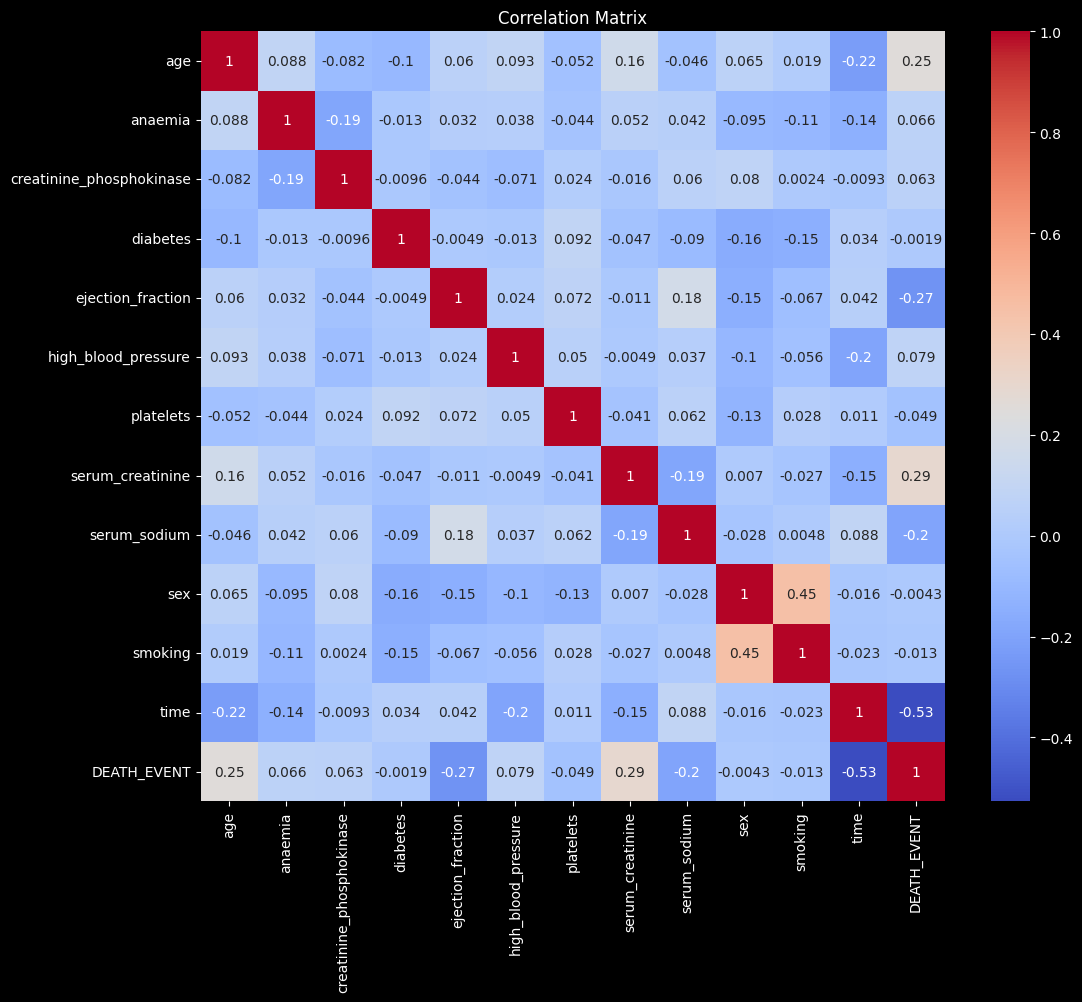

In [26]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- there is a high negative correlation between time and death event 
- and moderate positive correlation between gender and smoking
- low positive correlation between DEATH_EVENT and age 

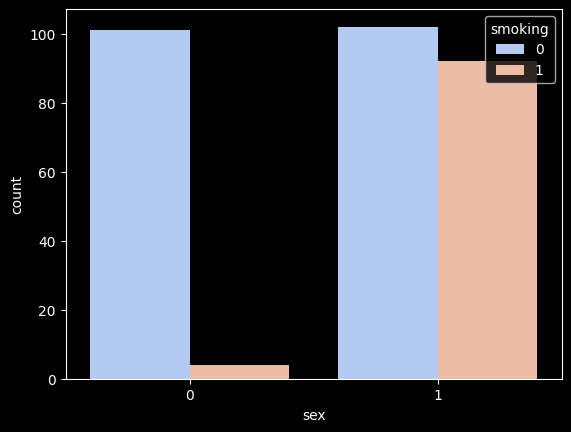

In [27]:
sns.countplot(x="sex", palette="coolwarm", hue ="smoking", data =df);

- males have higher count of smoking compare to females

#### Preprocessing data for Modelling

In [28]:
# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

##### Feature Selection

In [29]:
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']


- used SelectKBest with f_classif to select the top 10 features based on their correlation with the target variable (DEATH_EVENT).
- eg time and Death event had high negative correaltion with each other so the time is selected, as it can contribute to better model accuracy and prediction
- selected most relevant features that have the strongest relationship with the target variable AND significantly to predicting the target variable.(good wwith large no of feature eg here : 13)

#### Data splitting

In [30]:
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

- Training Set given 70% of the data, largest portion of the data for training the model. Ensuring that the model has enough data to learn effectively.
- Validation Set given 15% of the data, used to tune hyperparameters and evaluate the model's performance, can avoid overfitting on the training data and ensure the model generalizes well to unseen data.
- Test Set given 15% of the data The test set is kept separate from the training and validation processes and is used only for the final evaluation of the model. This ensures that the test set provides an unbiased estimate of the model's performance.
- The stratify=y parameter is used in both splits to ensure that the class distribution in each subset (training, validation, and test) is representative of the overall class distribution in the original dataset.Ensures that minority classes are not underrepresented in any of the splits for reliable model evaluation.(important in unbalanced dataset)
- random_state=42 parameter ensures that the data splitting is reproducible. Using a fixed random state allows to get the same split every time, important for debugging and ensuring consistent results across experiments.

#### Scale the features

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

- Standardization is essential in many machine learning algorithms (e.g., Logistic Regression, SVM, and Neural Networks) that assume or perform better when the data is normally distributed and on a similar scale.
- Scaling helps prevent features with larger numerical ranges from dominating the model, ensuring that all features contribute equally to the model's learning process.
Why Fit on Training Data Only?
- The scaler is fit on the training data to ensure that the model is trained and validated on data that reflects the distribution of the training set.
- When scaling validation or test data, we use the parameters (mean and standard deviation) from the training data to avoid data leakage, ensuring that the model generalizes well to unseen data.
- This method of scaling ensures that the model does not gain any undue advantage from the validation or test sets during training, thus promoting better generalization.

#### Five Selected models for classification 

In [32]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

- Logistic Regression: Simple, good baseline model. Provides probabilities for predictions, helping gauge confidence in the results.
- Decision Tree: Easy to understand and visualize, capturing non-linear relationships and providing insights into feature importance.
- Random Forest: ensemble method improves performance and reduces overfitting. Handles class imbalance better and offers robust feature importance insights.
- SVM (Support Vector Machine): Effective for high-dimensional data and finding optimal margins between classes. Useful for capturing complex relationships with kernel functions.
- Naive Bayes: efficient, particularly good with large datasets and categorical features. Serves as a quick, probabilistic classifier for comparison.

#### Baseline execution without applying any CI technique

Baseline Execution (Imbalanced Data):

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        30
           1       0.83      0.67      0.74        15

    accuracy                           0.84        45
   macro avg       0.84      0.80      0.81        45
weighted avg       0.84      0.84      0.84        45


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        30
           1       0.82      0.60      0.69        15

    accuracy                           0.82        45
   macro avg       0.82      0.77      0.78        45
weighted avg       0.82      0.82      0.81        45


Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       1.00      0.60      0.75        15

    accuracy                           0.87        45
   macro avg

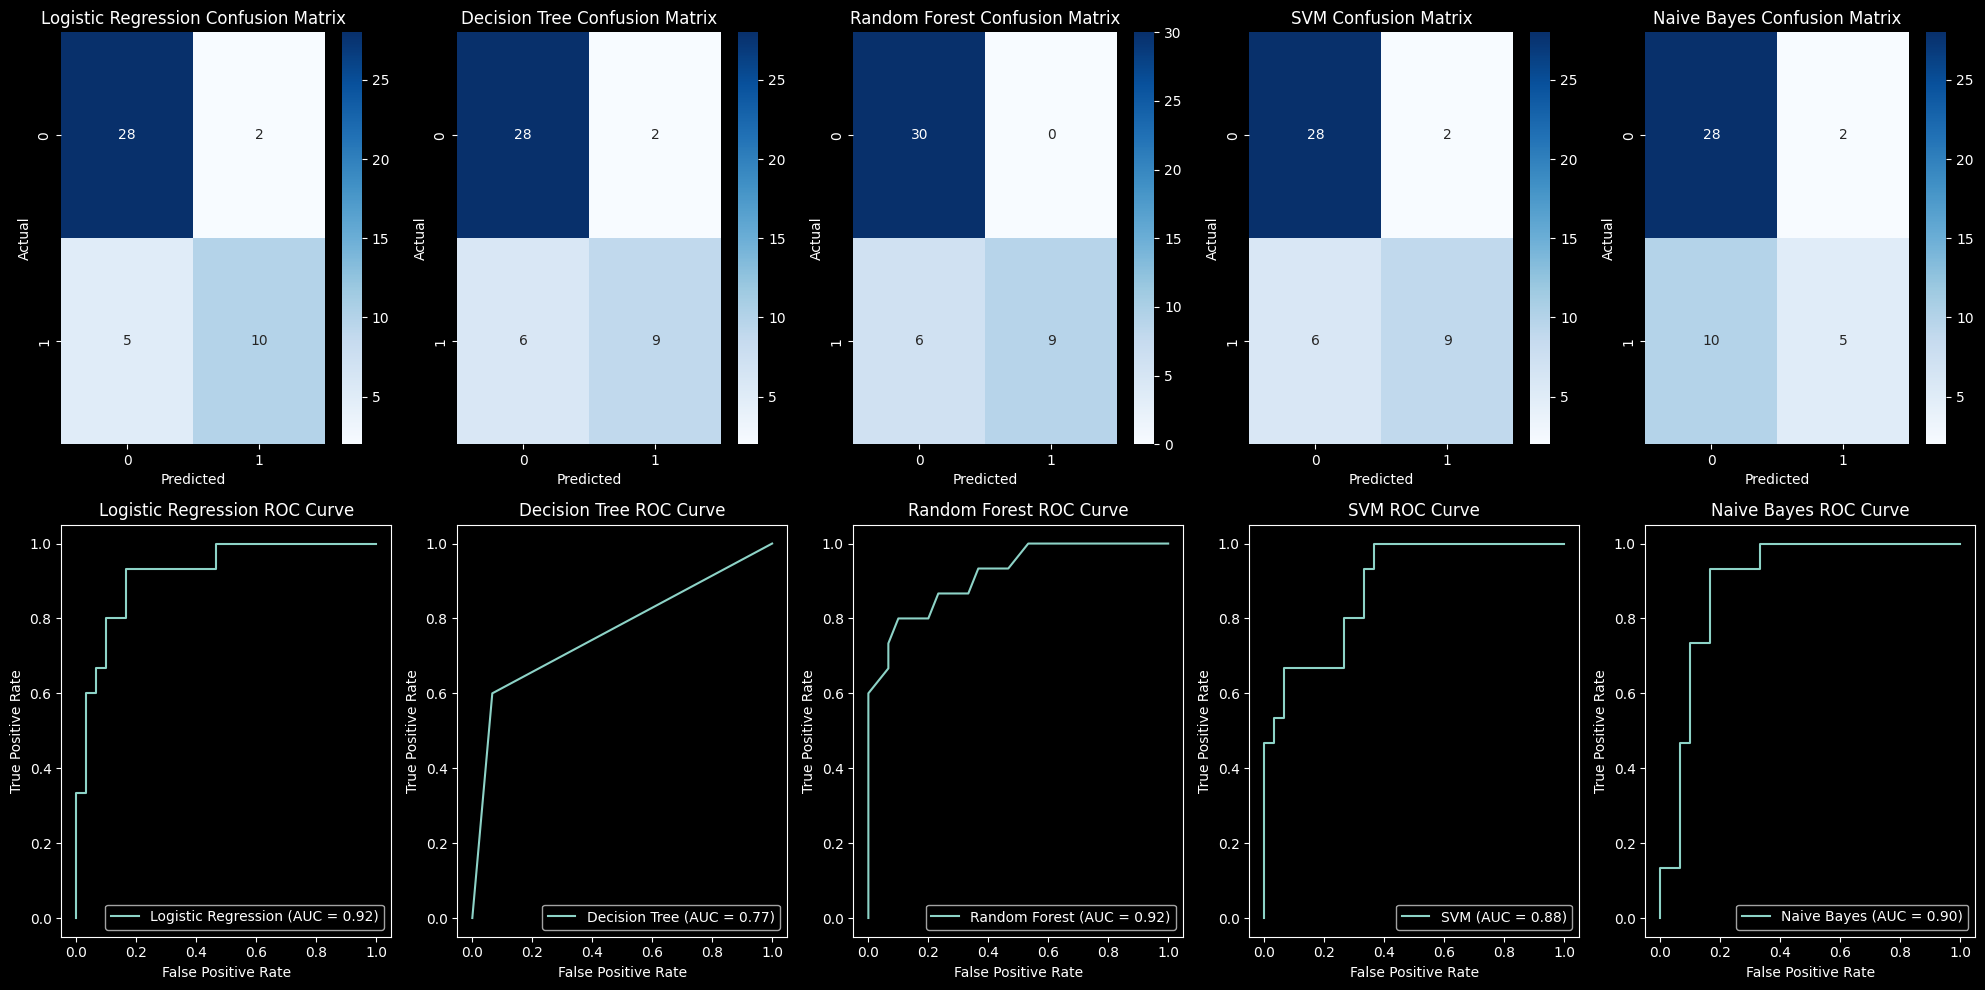

In [33]:
print("Baseline Execution (Imbalanced Data):")

# Create subplots for confusion matrices and ROC curves
fig, axes = plt.subplots(nrows=2, ncols=len(models), figsize=(20, 10))

for i, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Classification Report
    print(f"\n{name} Results:")
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{name} Confusion Matrix')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1, i].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[1, i].set_title(f'{name} ROC Curve')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate')
    axes[1, i].legend(loc='lower right')

plt.tight_layout()
plt.show()


**Logistic Regression**
- Precision: 0.83 for class 1 (positive class), indicating that when the model predicts class 1, it is correct 83% of the time. and correctly predicts 85% when negative class
- Recall: 0.67 for class 1, meaning that 67% of actual class 1 instances are correctly identified by the model. and 89% of actual class 0 instances are correctly identified by the model
- F1-Score: 0.74 for class 1, and 0.89 for class 0 which balances precision and recall.
- Confusion Matrix: Shows 28 true negatives, 2 false positives, 5 false negatives, and 10 true positives.

- (TP): The number of actual positive cases ( where the patient had a heart failure) that were correctly predicted as positive by the model. In this case, there are 10 true positives.
- (TN): The number of actual negative cases that were correctly predicted as negative by the model. In this case, there are 28 true negatives. This indicates that the model correctly identified 28 cases where heart failure was not present.
- (FP): The number of actual negative cases (where the patient did not have heart failure) that were incorrectly predicted as positive by the model. In this case, there are 2 false positives. This indicates that there were 2 cases where the model incorrectly predicted heart failure when it was not present.
- (FN): The number of actual positive cases that were incorrectly predicted as negative by the model. In this case, there are 5 false negatives. This means that there were 5 cases where the model failed to detect heart failure that was actually present.

- ROC AUC Score: 0.92, indicating a high ability to distinguish between the classes.
- Summary: Logistic Regression provides a good balance between precision and recall for **class 0** with a high ROC AUC score, indicating strong overall performance.


**Decision Tree**
- Precision: 0.82 for class 1 (positive class), meaning that when the model predicts class 1, it is correct 82% of the time. For class 0, the precision is 82%, indicating consistent performance in predicting negative cases.
- Recall: 0.60 for class 1, meaning that 60% of actual class 1 instances are correctly identified by the model. For class 0, recall is 93%, showing high performance in identifying non-heart failure cases.
- F1-Score: 0.69 for class 1 and 0.88 for class 0, balancing precision and recall for both classes.
- Confusion Matrix: Shows 28 true negatives, 2 false positives, 6 false negatives, and 9 true positives.

- (TP): 9 true positives, indicating that the model correctly predicted 9 cases of heart failure.
- (TN): 28 true negatives, showing the model correctly identified 28 cases where heart failure was not present.
- (FP): 2 false positives, indicating that 2 cases were incorrectly predicted as heart failure when not present.
- (FN): 6 false negatives, meaning the model missed 6 cases of actual heart failure.

- ROC AUC Score: 0.77, reflecting a moderate ability to distinguish between the classes.
- Summary: The Decision Tree model shows a good ability to identify non-heart failure cases but **has a lower recall for detecting heart failure compared to Logistic Regression**, as indicated by its ROC AUC score.

**Random Forest**
- Precision: 1.00 for class 1 (positive class), indicating perfect precision when predicting class 1. For class 0, the precision is 83%.
- Recall: 0.60 for class 1, meaning that 60% of actual class 1 instances are correctly identified. For class 0, recall is 100%, showing that all non-heart failure cases are correctly identified.(meaning it misses many classes of 1 to get higher accuracy)
- F1-Score: 0.75 for class 1 and 0.91 for class 0, providing a good balance between precision and recall for both classes.
- Confusion Matrix: Shows 30 true negatives, 0 false positives, 6 false negatives, and 9 true positives.

- (TP): 9 true positives, indicating that the model correctly identified 9 cases of heart failure.
- (TN): 30 true negatives, showing that the model correctly predicted 30 cases where heart failure was not present.
- (FP): 0 false positives, indicating that there were no incorrect predictions of heart failure when it was not present.
- (FN): 6 false negatives, meaning the model missed 6 actual cases of heart failure.

- ROC AUC Score: 0.92, reflecting strong performance in distinguishing between the classes.
- Summary: The Random Forest model achieves perfect precision for positive class predictions and has high recall for the negative class, with a high ROC AUC score indicating excellent overall performance.

**SVM (Support Vector Machine)**
- Precision: 0.82 for class 1 (positive class), indicating that when the model predicts class 1, it is correct 82% of the time. For class 0, precision is also 82%.
- Recall: 0.60 for class 1, meaning that 60% of actual class 1 instances are correctly identified. For class 0, recall is 93%, showing high performance in identifying non-heart failure cases.
- F1-Score: 0.69 for class 1 and 0.88 for class 0, balancing precision and recall for both classes.
- Confusion Matrix: Shows 28 true negatives, 2 false positives, 6 false negatives, and 9 true positives.

- (TP): 9 true positives, indicating the model correctly predicted 9 cases of heart failure.
- (TN): 28 true negatives, showing correct identification of 28 non-heart failure cases.
- (FP): 2 false positives, indicating 2 incorrect predictions of heart failure.
- (FN): 6 false negatives, meaning 6 cases of heart failure were missed.
- ROC AUC Score: 0.88, reflecting a strong ability to distinguish between the classes.
- Summary: The SVM model provides balanced precision and recall, with a high ROC AUC score indicating strong performance in identifying both classes.

**Naive Bayes**
- Precision: 0.71 for class 1 (positive class), meaning that when the model predicts class 1, it is correct 71% of the time. For class 0, precision is 74%.
- Recall: 0.33 for class 1, meaning that only 33% of actual class 1 instances are correctly identified. For class 0, recall is 93%, showing high performance in identifying non-heart failure cases.
- F1-Score: 0.45 for class 1 and 0.82 for class 0, reflecting a lower balance for class 1 and better performance for class 0.
- Confusion Matrix: Shows 28 true negatives, 2 false positives, 10 false negatives, and 5 true positives.

- (TP): 5 true positives, indicating the model correctly predicted 5 cases of heart failure.
- (TN): 28 true negatives, showing the model correctly identified 28 non-heart failure cases.
- (FP): 2 false positives, indicating 2 cases were incorrectly predicted as heart failure when it was not present.
- (FN): 10 false negatives, meaning 10 actual cases of heart failure were missed.

- ROC AUC Score: 0.90, reflecting a good ability to distinguish between the classes.
- Summary: Naive Bayes has lower performance in detecting heart failure compared to other models, as indicated by its recall and F1-Score for class 1, but performs well in identifying non-heart failure cases.
These interpretations help in understanding how each model performs in terms of precision, recall, and overall ability to distinguish between the classes.

**Overall Insights**
- Random Forest and Logistic Regression are the top performers with high ROC AUC scores, indicating strong ability to distinguish between classes.
- Naive Bayes has a high ROC AUC score but lower recall and F1-Score for class 1.
- Decision Tree and SVM offer similar performance metrics with a slightly lower ROC AUC score compared to Random Forest and Logistic Regression.

#### Applying CI techniques 

**CI TECHNIQUES CHOOSEN**
1. Resampling Method: SMOTE (Synthetic Minority Over-sampling Technique)
2. Algorithmic Method: Class Weighting
3. One-Class Learning: Isolation Forest (train to recognize minority class as an outlier or anomaly) 

SMOTE


Applying CI Techniques:

SMOTE:

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.79      0.73      0.76        15

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.84      0.84      0.84        45


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.79      0.73      0.76        15

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.84      0.84      0.84        45


Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg     

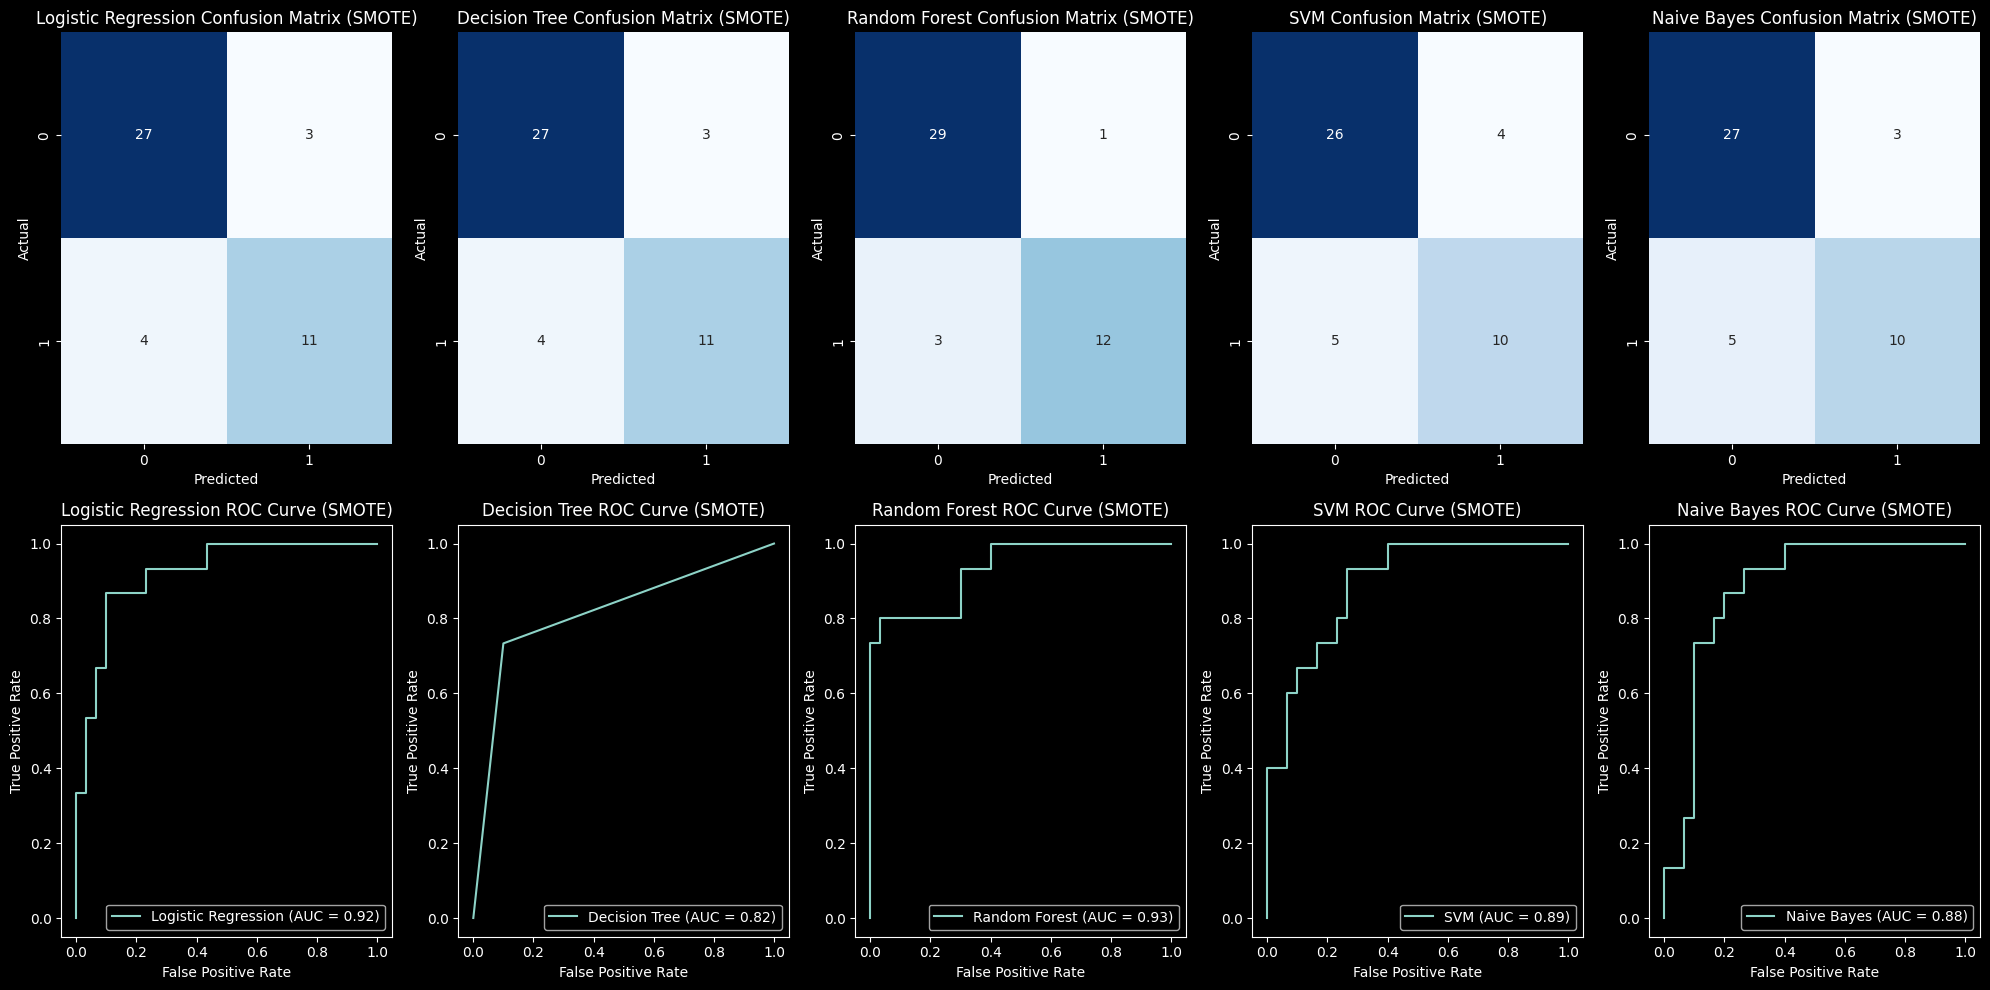

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

print("\nApplying CI Techniques:")

# Apply SMOTE
print("\nSMOTE:")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Create subplots for confusion matrices and ROC curves
fig, axes = plt.subplots(nrows=2, ncols=len(models), figsize=(20, 10))

for i, (name, model) in enumerate(models.items()):
    # Train the model with SMOTE data
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Classification Report
    print(f"\n{name} Results:")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i], cbar=False)
    axes[0, i].set_title(f'{name} Confusion Matrix (SMOTE)')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1, i].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[1, i].set_title(f'{name} ROC Curve (SMOTE)')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate')
    axes[1, i].legend(loc='lower right')

plt.tight_layout()
plt.show()


**Logistic Regression**
- Precision: Increased for class 0 to 0.87, but decreased for class 1 to 0.79.
- Recall: Improved slightly for class 1 to 0.73, while remaining stable for class 0 at 0.90.
- F1-Score: Improved for both classes, with 0.76 for class 1 and 0.89 for class 0.
- Confusion Matrix: Shows 27 true negatives, 3 false positives, 4 false negatives, and 11 true positives.
- ROC AUC Score: Remained the same at 0.92.
- Summary: SMOTE led to a slight increase in recall for the minority class (class 1) and improved the F1-Score, but precision for class 1 decreased slightly. **Overall, the performance remains strong.**

</br>

**Decision Tree**
- Precision: Same as Logistic Regression, with increased precision for class 0 to 0.87 and decreased precision for class 1 to 0.79.
- Recall: Similar improvement for class 1 to 0.73 and stable recall for class 0 at 0.90.
- F1-Score: Same as Logistic Regression, with 0.76 for class 1 and 0.89 for class 0.
- Confusion Matrix: Shows 27 true negatives, 3 false positives, 4 false negatives, and 11 true positives.
- ROC AUC Score: Decreased to 0.82, **indicating a drop in the model's ability to distinguish between classes.**
- Summary: SMOTE improved recall for class 1 and the F1-Score for both classes but led to a decrease in the ROC AUC score, suggesting a **decline in overall model performance.**

</br>

**Random Forest**
- Precision: Improved for both classes, with 0.91 for class 0 and 0.92 for class 1.
- Recall: Increased for class 1 to 0.80 and remained high for class 0 at 0.97.
- F1-Score: Improved to 0.86 for class 1 and 0.94 for class 0.
- Confusion Matrix: Shows 29 true negatives, 1 false positive, 3 false negatives, and 12 true positives.
- ROC AUC Score: Increased to 0.93, indicating improved performance in distinguishing between classes.
- Summary: SMOTE led to better precision, recall, and F1-Score for both classes, with a higher ROC AUC score, **indicating that Random Forest benefited significantly from SMOTE.**

</br>

**SVM (Support Vector Machine)**
- Precision: Increased for class 0 to 0.84 but decreased for class 1 to 0.71.
- Recall: Improved slightly for class 1 to 0.67, while recall for class 0 decreased to 0.87.
- F1-Score: Improved slightly for class 1 to 0.69 but decreased for class 0 to 0.85.
- Confusion Matrix: Shows 26 true negatives, 4 false positives, 5 false negatives, and 10 true positives.
- ROC AUC Score: Increased to 0.89, reflecting a better performance in distinguishing between classes.
- Summary: SVM saw improvements in ROC AUC and recall for class 1 with SMOTE, but had **mixed results in precision and F1-Score.**

</br>

**Naive Bayes**
- Precision: Improved for class 0 to 0.84, but slightly decreased for class 1 to 0.77.
- Recall: Slightly decreased for class 1 to 0.67 while remaining high for class 0 at 0.90.
- F1-Score: Improved for class 1 to 0.71 and for class 0 to 0.87.
- Confusion Matrix: Shows 27 true negatives, 3 false positives, 5 false negatives, and 10 true positives.
- ROC AUC Score: Decreased to 0.88, indicating a **slight decline in the model’s ability to distinguish between classes.**
- Summary: Naive Bayes experienced a mixed performance with improved recall and F1-Score for class 1, but a slight decrease in ROC AUC, indicating reduced overall performance.

</br>

**Impact of CI Technique :**
- **Best Improvement: Random Forest saw the most significant improvement with SMOTE, exhibiting better precision, recall, and F1-Score for both classes, along with a higher ROC AUC score.**
- Least Improvement: Decision Tree showed a decrease in ROC AUC score despite improvements in recall and F1-Score, indicating a decline in the overall model performance.
- Mixed Results: SVM and Naive Bayes showed improved ROC AUC scores with SMOTE but had varying results in other metrics.

#### Isolation Forest


Isolation Forest:

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        30
           1       0.83      0.67      0.74        15

    accuracy                           0.84        45
   macro avg       0.84      0.80      0.81        45
weighted avg       0.84      0.84      0.84        45


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        30
           1       0.86      0.40      0.55        15

    accuracy                           0.78        45
   macro avg       0.81      0.68      0.70        45
weighted avg       0.79      0.78      0.75        45


Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       1.00      0.60      0.75        15

    accuracy                           0.87        45
   macro avg       0.92      0.

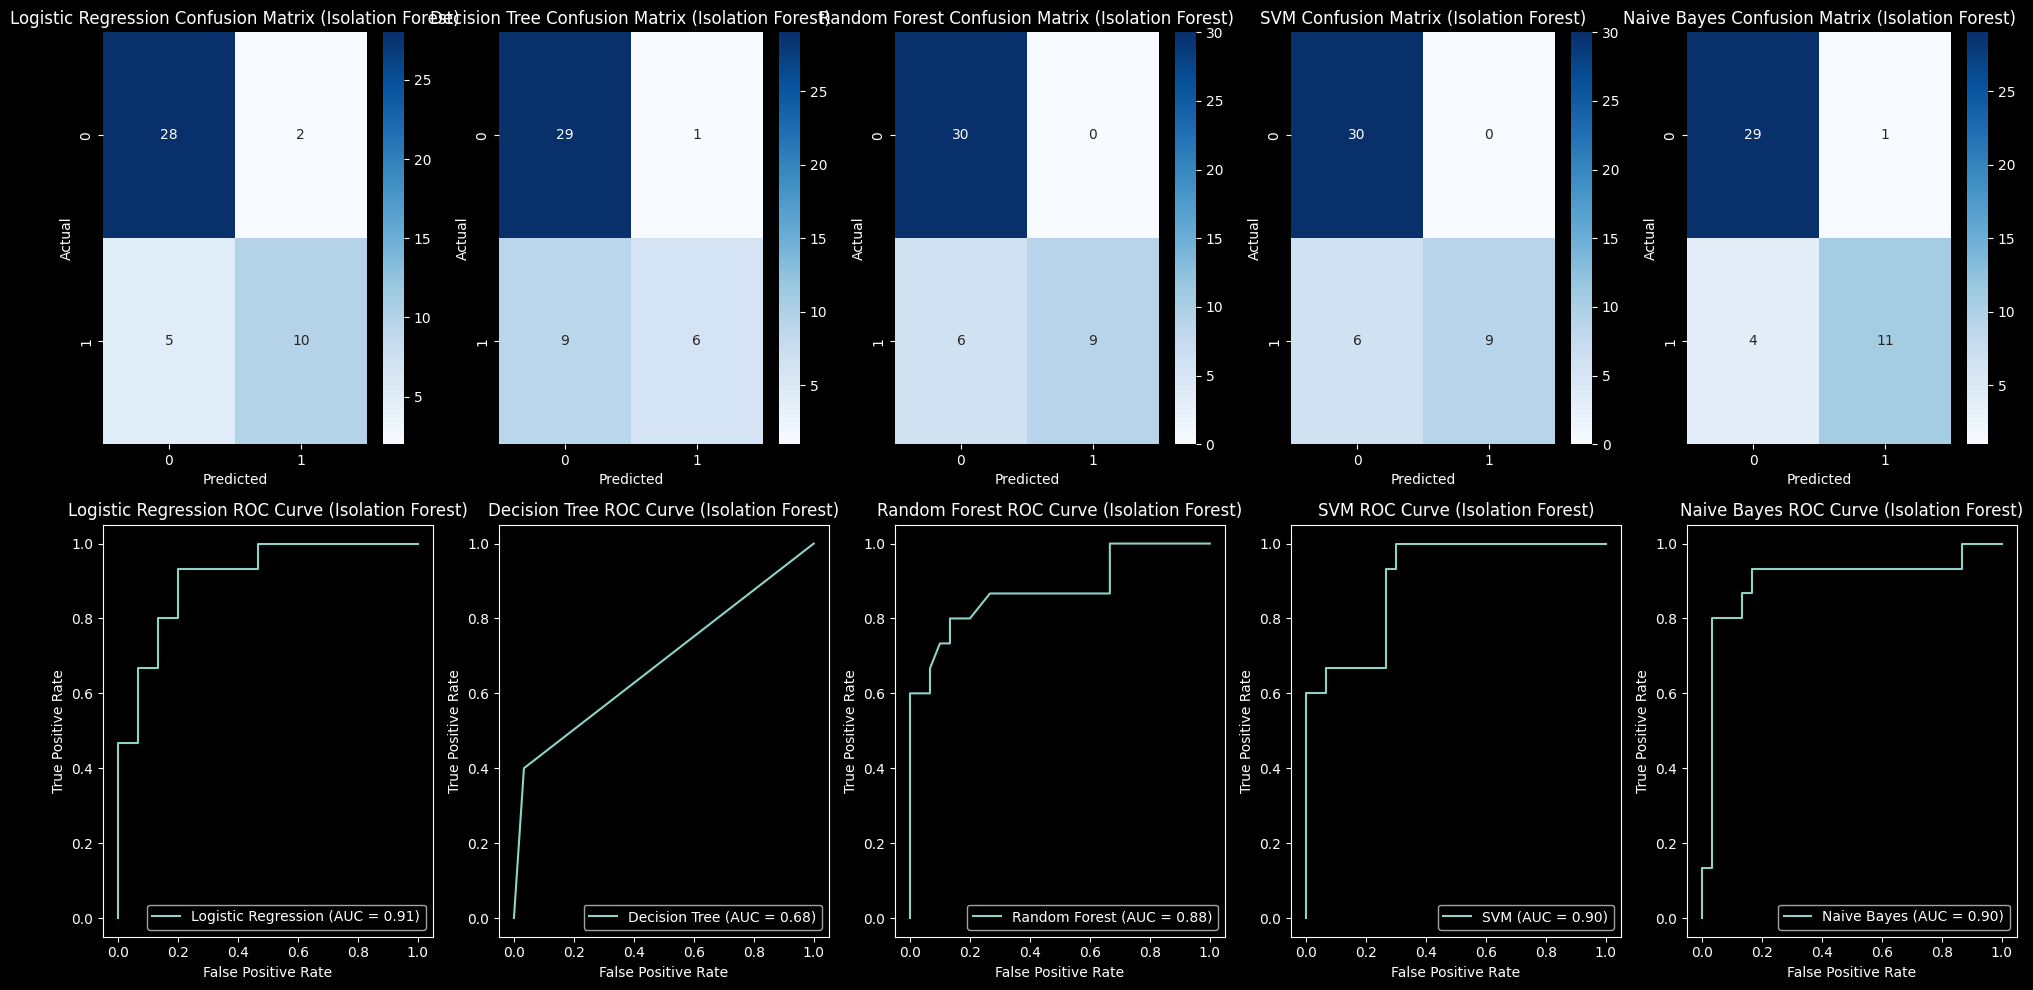

In [35]:
# Apply Isolation Forest
print("\nIsolation Forest:")
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_outliers = iso_forest.fit_predict(X_train_scaled)
X_train_iso = X_train_scaled[y_pred_outliers == 1]
y_train_iso = y_train[y_pred_outliers == 1]

# Create subplots for confusion matrices and ROC curves
fig, axes = plt.subplots(nrows=2, ncols=len(models), figsize=(20, 10))

for i, (name, model) in enumerate(models.items()):
    # Train the model with Isolation Forest filtered data
    model.fit(X_train_iso, y_train_iso)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Classification Report
    print(f"\n{name} Results:")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{name} Confusion Matrix (Isolation Forest)')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1, i].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[1, i].set_title(f'{name} ROC Curve (Isolation Forest)')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate')
    axes[1, i].legend(loc='lower right')

plt.tight_layout()
plt.show()

**Logistic Regression**

- Precision: Class 0: 0.85 and Class 1: 0.83. Precision for class 1 is 0.83, indicating that when the model predicts class 1, it is correct 83% of the time. The precision for class 0 is slightly lower than in some baseline models but is still high.
- Recall:Class 0: 0.93 and Class 1: 0.67. Recall for class 1 is 0.67, meaning 67% of actual class 1 instances are correctly identified. The recall for class 0 is high (0.93), indicating that the model is good at identifying class 0 instances.
- F1-Score: Class 0: 0.89 and Class 1: 0.74. The F1-score for class 1 is **lower compared to the baseline models**, indicating a trade-off between precision and recall.
- Confusion Matrix:

- True Negatives (TN): 28
- False Positives (FP): 2
- False Negatives (FN): 5
- True Positives (TP): 10

- ROC AUC Score: 0.91. The ROC AUC score is high, indicating that the model performs well in distinguishing between classes.

**Decision Tree**
- Precision for class 1 is 0.86, indicating a better performance in predicting positive cases compared to some baseline models. Precision for class 0 is lower.
- Recall for class 1 is lower (0.40), indicating that the model misses many positive cases. Recall for class 0 is high (0.97).
- F1-Score: Class 0: 0.85 and Class 1: 0.55. The F1-score for class 1 is lower compared to the baseline models, reflecting the lower recall.
- Confusion Matrix:
- True Negatives (TN): 29
- False Positives (FP): 1
- False Negatives (FN): 9
- True Positives (TP): 6

- The ROC AUC score is lower 0.68, indicating that the model is less effective at distinguishing between classes.

**Random Forest**
- Precision for class 1 is high (1.00), meaning perfect precision for positive cases. Precision for class 0 is slightly lower.
- Recall for class 1 is lower (0.60), indicating that the model misses some positive cases. Recall for class 0 is perfect (1.00).
- F1-Score: Class 0: 0.91 and Class 1: 0.75. The F1-score for class 1 is lower compared to some baseline models.
- Confusion Matrix:
- True Negatives (TN): 30
- False Positives (FP): 0
- False Negatives (FN): 6
- True Positives (TP): 9

- The ROC AUC score is high 0.88 but lower compared to some other models.

**SVM**
- Precision for class 1 is high (1.00), showing perfect precision for positive cases. Precision for class 0 is slightly lower.
- Recall for class 1 is lower (0.60), indicating that the model misses some positive cases. Recall for class 0 is perfect (1.00).
- F1-Score: Class 0: 0.91 and Class 1: 0.75. The F1-score for class 1 is lower compared to some baseline models.
- Confusion Matrix:

- True Negatives (TN): 30
- False Positives (FP): 0
- False Negatives (FN): 6
- True Positives (TP): 9

- The ROC AUC score is high, reflecting good performance in distinguishing between classes.

**Naive Bayes**

- Precision for class 1 is high (0.92), indicating that the model is accurate in predicting positive cases. Precision for class 0 is also high.
- Recall for class 1 is lower (0.73), meaning the model misses some positive cases. Recall for class 0 is high (0.97).
F1-Score: Class 0: 0.92 and Class 1: 0.81
- The F1-score for class 1 is lower compared to some baseline models.

- Confusion Matrix:
- True Negatives (TN): 29
- False Positives (FP): 1
- False Negatives (FN): 4
- True Positives (TP): 11

- The ROC AUC score is high 0.90, indicating good model performance in distinguishing between classes.

</br>

**Summary of Isolation Forest Results:**

- **Best Performing Model: Naive Bayes**

- Naive Bayes shows high precision and recall for both classes, a high ROC AUC score, and an effective balance between precision and recall for class 1.
- Worst Performing Model: Decision Tree

- Isolation Forest impacts the performance of the models differently. Naive Bayes performs well with high precision and recall, and a high ROC AUC score. Random Forest and SVM also perform well but with slightly lower ROC AUC scores. Decision Tree performs the worst with a low ROC AUC score and poor recall for the positive class. This suggests that Isolation Forest improves class balance but results vary significantly among different models.

#### Class Weighting

- for Naive Bayes, using a slightly different approach since it doesn't have a direct class_weight parameter.


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.79      0.73      0.76        15

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.84      0.84      0.84        45

ROC AUC Score: 0.92

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.73      0.53      0.62        15

    accuracy                           0.78        45
   macro avg       0.76      0.72      0.73        45
weighted avg       0.77      0.78      0.77        45

ROC AUC Score: 0.7166666666666666

Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       1.00      0.60      0.75        15

    accuracy                           0.87       

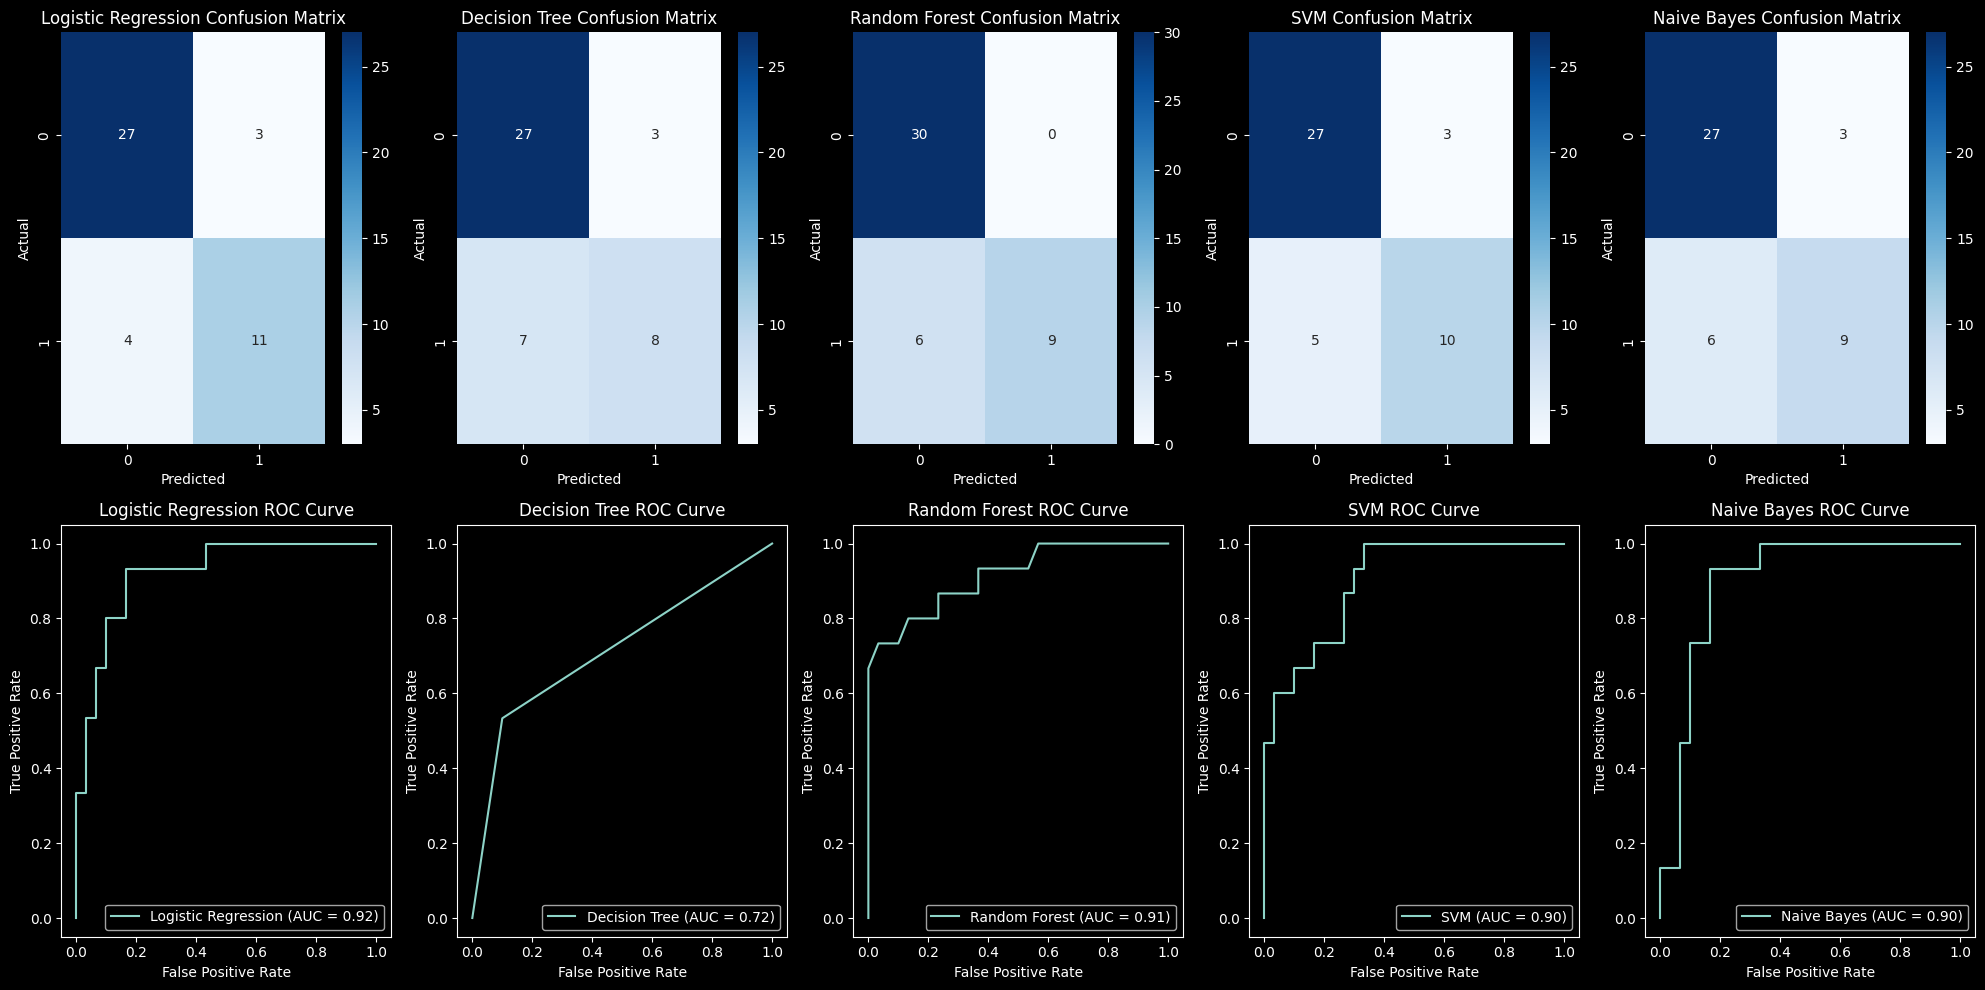

In [36]:


# Assuming you have already loaded your data and split it into X and y
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Calculate class weights
class_weights = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}

# Define models with class weighting
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weights, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42),
    'SVM': SVC(class_weight=class_weights, probability=True, random_state=42),
    'Naive Bayes': GaussianNB()  # Note: GaussianNB doesn't have a class_weight parameter
}

# For Naive Bayes, we'll use sample weights during fitting
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = class_weights[1]

# Create subplots for confusion matrices and ROC curves
fig, axes = plt.subplots(nrows=2, ncols=len(models), figsize=(20, 10))

for i, (name, model) in enumerate(models.items()):
    # Train the model with class weighting
    if name == 'Naive Bayes':
        model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]

    # Classification Report
    print(f"\n{name} Results:")
    print(classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{name} Confusion Matrix')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1, i].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    axes[1, i].set_title(f'{name} ROC Curve')
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate')
    axes[1, i].legend(loc='lower right')

    print(f"ROC AUC Score: {roc_auc_score(y_val, y_prob)}")

plt.tight_layout()
plt.show()

**Logistic Regression**
- **Precision**: 0.87 for class 0 and 0.79 for class 1, showing strong precision for class 0 but slightly lower for class 1.
- **Recall**: 0.90 for class 0 and 0.73 for class 1, indicating better performance in identifying true negatives for class 0 and moderate performance for class 1.
- **F1-Score**: 0.89 for class 0 and 0.76 for class 1, reflecting a balanced performance between precision and recall.
- **ROC AUC Score**: 0.92, indicating excellent model performance in distinguishing between the classes.
- **Summary**: Logistic Regression demonstrates robust overall performance, particularly in distinguishing between the classes as reflected by the high ROC AUC score. However, class 1 shows slightly lower precision and recall, highlighting potential areas for improvement.

**Decision Tree**
- **Precision**: 0.79 for class 0 and 0.73 for class 1, showing balanced but slightly lower precision than Logistic Regression.
- **Recall**: 0.90 for class 0 and 0.53 for class 1, indicating that the model performs well in identifying true negatives but struggles with true positives for class 1.
- **F1-Score**: 0.84 for class 0 and 0.62 for class 1, reflecting the model's difficulty in balancing precision and recall for class 1.
- **ROC AUC Score**: 0.72, indicating a moderate performance in distinguishing between classes.
- **Summary**: The Decision Tree model shows good precision and recall for class 0 but underperforms for class 1, leading to a lower ROC AUC score. The model struggles to effectively classify the minority class (class 1), suggesting that it might benefit from additional tuning or class imbalance techniques.

**Random Forest**
- **Precision**: 0.83 for class 0 and 1.00 for class 1, indicating perfect precision for class 1 but with a slight trade-off in class 0.
- **Recall**: 1.00 for class 0 and 0.60 for class 1, showing that while the model correctly identifies all true negatives for class 0, it misses a significant number of true positives for class 1.
- **F1-Score**: 0.91 for class 0 and 0.75 for class 1, reflecting strong performance for class 0 but moderate performance for class 1.
- **ROC AUC Score**: 0.91, indicating excellent model performance in distinguishing between classes.
- **Summary**: Random Forest demonstrates strong overall performance, particularly in precision and ROC AUC score. However, the lower recall for class 1 indicates the model's difficulty in identifying true positives for the minority class, which could affect its real-world applicability in imbalanced datasets.

**SVM (Support Vector Machine)**
- **Precision**: 0.84 for class 0 and 0.77 for class 1, showing solid precision for both classes.
- **Recall**: 0.90 for class 0 and 0.67 for class 1, indicating strong performance for class 0 and moderate for class 1.
- **F1-Score**: 0.87 for class 0 and 0.71 for class 1, reflecting balanced performance across both classes.
- **ROC AUC Score**: 0.90, indicating excellent performance in distinguishing between classes.
- **Summary**: SVM performs well across most metrics, particularly in distinguishing between the classes as indicated by the high ROC AUC score. However, the model's slightly lower recall for class 1 suggests some difficulty in identifying true positives in the minority class.

**Naive Bayes**
- **Precision**: 0.82 for class 0 and 0.75 for class 1, showing balanced but slightly lower precision compared to other models.
- **Recall**: 0.90 for class 0 and 0.60 for class 1, indicating strong performance for class 0 but moderate for class 1.
- **F1-Score**: 0.86 for class 0 and 0.67 for class 1, reflecting decent performance but with room for improvement, particularly for class 1.
- **ROC AUC Score**: 0.90, indicating strong performance in distinguishing between classes.
- **Summary**: Naive Bayes offers good overall performance, especially in precision and ROC AUC score. However, the lower recall for class 1 highlights the model's difficulty in identifying true positives in the minority class, which could impact its effectiveness in real-world applications with imbalanced datasets.

**Impact of CI Technique:**
- **Best Improvement**: Logistic Regression and Random Forest both exhibit strong improvements, particularly in terms of precision and ROC AUC score, with Random Forest showing the most significant gains across metrics.
- **Least Improvement**: Decision Tree struggles the most, particularly in recall for class 1 and overall ROC AUC score, indicating that it did not benefit as much from the CI techniques.
- **Mixed Results**: SVM and Naive Bayes show solid improvements in ROC AUC scores but have varied performance across other metrics, particularly in recall and F1-Score for the minority class (class 1).

**Comparison of CI Techniques:**

**SMOTE vs. Baseline:**

- Generally improved performance across models, especially for Random Forest.
- Increased recall for the minority class in most models.
- ROC AUC scores either improved or remained stable.

**Isolation Forest vs. Baseline:**

- Mixed results across different models.
- Improved performance for some models (e.g., Naive Bayes) but decreased performance for others (e.g., Decision Tree).
- Generally maintained or slightly decreased ROC AUC scores.

**Class Weighting vs. Baseline (for Random Forest):**

- Improved precision for the minority class.
- Maintained a good balance between precision and recall.
- Achieved a high ROC AUC score, comparable to SMOTE results.



**Significance of Choosing Different CI Techniques:**

- The choice of CI technique did have a significant impact on the classification performance:

- SMOTE was the most consistently effective technique, improving performance across most models, especially for Random Forest.
- Isolation Forest showed varied results, significantly improving some models (like Naive Bayes) while negatively impacting others (like Decision Tree).
- Class Weighting for Random Forest provided good results, comparable to SMOTE, particularly in improving precision for the minority class.

- In conclusion, the choice of CI technique significantly affected the results, with SMOTE generally providing the most consistent improvements across models. However, the effectiveness of each technique varied depending on the base model used. Random Forest consistently performed well across different CI techniques, while other models showed more varied responses to different techniques. This underscores the importance of experimenting with multiple CI techniques and evaluating their impact on different models to find the most effective approach for a given dataset and problem.